### Import required Libraries

In [25]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    RocCurveDisplay
)

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import joblib


### Load Dataset

In [26]:
df = pd.read_csv("D:\All_Projects\Prayatna\Duplicate Detection\duplicate_detection_50000_v4.csv")

print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (64276, 11)


,aadhaar_like_id,name,household_id,phone_number,bank_account,district,is_duplicate,aadhaar_count,phone_count,bank_count,household_size
0,601280946403,Anil Yalav,HH81006,7156165247,BA13270646,District_18,1,2.149014,5.969265,5.963892,4.175746
1,858281453592,Pooja Kumar,HH60605,9917634580,BA72440282,District_12,0,1.000000,1.351949,1.000000,1.455022
2,625894445531,Amit Patel,HH55568,6885344485,BA90072749,District_12,0,2.194307,2.242120,2.046162,6.562088
3,404288605053,Anil Kumar,HH66186,9081126003,BA08356691,District_9,1,3.456909,3.114958,3.377375,4.084884
4,90742501017,Amit Patel,HH39588,7901660251,BA53301333,District_3,1,1.000000,2.761309,3.345260,1.381671


### Check Missing Values

In [27]:
# ===============================
# Missing value check
# ===============================

df.isnull().sum()

aadhaar_like_id    0
name               0
household_id       0
phone_number       0
bank_account       0
district           0
is_duplicate       0
aadhaar_count      0
phone_count        0
bank_count         0
household_size     0
dtype: int64

### Features & Target

In [28]:
X = df.drop(columns=["is_duplicate"])
y = df["is_duplicate"]

### Column Types

In [29]:
categorical_cols = [
    "aadhaar_like_id",
    "name",
    "household_id",
    "phone_number",
    "bank_account",
    "district"
]

numeric_cols = [
    "aadhaar_count",
    "phone_count",
    "bank_count",
    "household_size"
]

### Preprocessing + XGBoost Pipeline

In [30]:
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", encoder, categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", xgb_model)
])


### Train-Test Split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

### Train

In [32]:
pipeline.fit(X_train, y_train)

print("Training completed.")

Training completed.


### Predictions

In [33]:
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

### Evaluation

In [34]:
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nReport:\n", classification_report(y_test, y_pred))


Accuracy: 0.9328
ROC-AUC: 0.9809

Confusion Matrix:
 [[7272  728]
 [ 136 4720]]

Report:
               precision    recall  f1-score   support

           0       0.98      0.91      0.94      8000
           1       0.87      0.97      0.92      4856

    accuracy                           0.93     12856
   macro avg       0.92      0.94      0.93     12856
weighted avg       0.94      0.93      0.93     12856



### ROC Curve

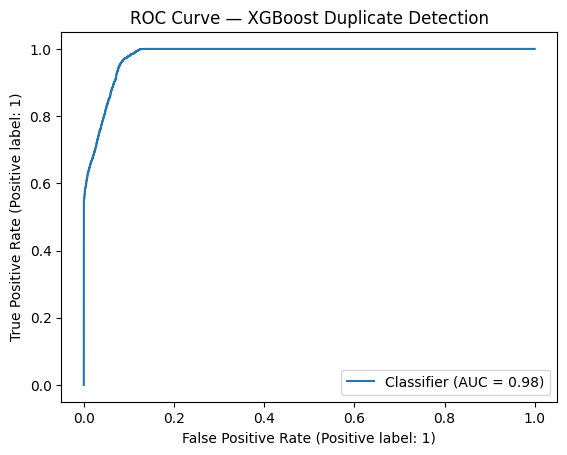

In [35]:
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve — XGBoost Duplicate Detection")
plt.show()

### Feature Importance

In [38]:

xgb_model = pipeline.named_steps["model"]

# Feature names in correct order
feature_names = categorical_cols + numeric_cols

# Extract importance
importances = pd.Series(xgb_model.feature_importances_, index=feature_names)
importances = importances.sort_values(ascending=False)

print("Feature Importance:\n")
print(importances)


Feature Importance:

bank_count         0.643671
phone_count        0.214614
aadhaar_count      0.064860
household_size     0.018025
name               0.014981
district           0.008980
aadhaar_like_id    0.008901
bank_account       0.008850
household_id       0.008592
phone_number       0.008525
dtype: float32


### Plot Feature Importance

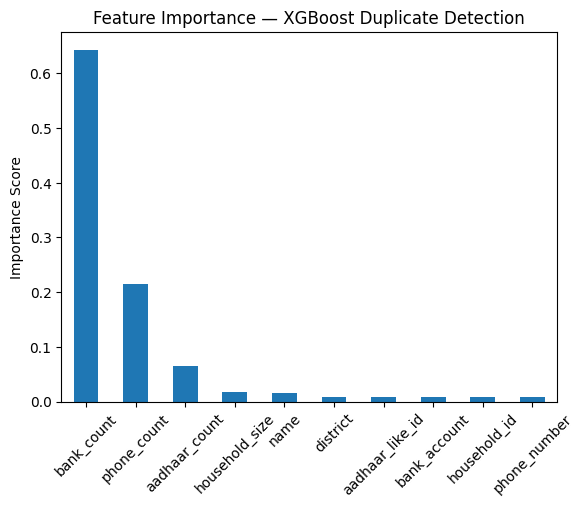

In [39]:
import matplotlib.pyplot as plt

plt.figure()
importances.plot(kind="bar")
plt.title("Feature Importance — XGBoost Duplicate Detection")
plt.ylabel("Importance Score")
plt.xticks(rotation=45)
plt.show()


### Test for Duplicate

In [36]:
sample = pd.DataFrame([{
    "aadhaar_like_id": "123456789012",
    "name": "Rahul Sharma",
    "household_id": "HH12345",
    "phone_number": "9876543210",
    "bank_account": "BA12345678",
    "district": "District_5",
    "aadhaar_count": 3,
    "phone_count": 6,
    "bank_count": 5,
    "household_size": 4
}])

pred = pipeline.predict(sample)[0]
prob = pipeline.predict_proba(sample)[0][1]

print("Prediction:", "Duplicate" if pred == 1 else "Normal")
print("Probability:", round(prob, 4))


Prediction: Duplicate
Probability: 0.9581


### Test for Non-Duplicate ones

In [41]:
# =====================================
# Manual test — NON duplicate case
# =====================================

normal_sample = pd.DataFrame([{
    "aadhaar_like_id": "888877776666",
    "name": "Amit Verma",
    "household_id": "HH54321",
    "phone_number": "9123456780",
    "bank_account": "BA87654321",
    "district": "District_3",
    "aadhaar_count": 1,
    "phone_count": 1,
    "bank_count": 1,
    "household_size": 2
}])

pred = pipeline.predict(normal_sample)[0]
prob = pipeline.predict_proba(normal_sample)[0][1]

# =====================================
# Pretty probability formatting
# =====================================

prob_percent = prob * 100

print("Prediction:", "Duplicate" if pred == 1 else "Normal")
print(f"Duplicate Probability: {prob_percent:.4f}%")


Prediction: Normal
Duplicate Probability: 0.0065%


### Save Production Pipeline

In [37]:
joblib.dump(pipeline, "duplicate_detection_pipeline_xgb.pkl")

print("Saved production XGBoost pipeline.")


Saved production XGBoost pipeline.
